In [65]:
%matplotlib widget

from sklearn.datasets import load_diabetes
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import math

In [66]:
np.set_printoptions(precision=15)

diabetes = load_diabetes(scaled=True) # enable Feature Scaling
data = diabetes.data # (m x n) (examples x features)

severity = diabetes.target.reshape((-1,1)) # output of severity of diabetes or disease progression
# mx1

print(data.dtype, severity.dtype) # show datatypes of input and output
print(data.shape) # show shape of input
print(diabetes.feature_names) # show feature names associated with input
print(data)# show data itself

float64 float64
(442, 10)
['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
[[ 0.038075906433423  0.050680118739819  0.061696206518683 ...
  -0.002592261998183  0.019907486170463 -0.017646125159804]
 [-0.001882016527791 -0.044641636506989 -0.051474061238801 ...
  -0.039493382874093 -0.068331547093973 -0.092204049626824]
 [ 0.085298906296675  0.050680118739819  0.04445121333659  ...
  -0.002592261998183  0.002861309289833 -0.025930338989473]
 ...
 [ 0.041708444884442  0.050680118739819 -0.015906262800734 ...
  -0.011079519799643 -0.046882534152732  0.015490730158872]
 [-0.045472477940024 -0.044641636506989  0.039062152967186 ...
   0.026559623493786  0.044528728819971 -0.025930338989473]
 [-0.045472477940024 -0.044641636506989 -0.073030302716417 ...
  -0.039493382874093 -0.004221513938108  0.003064409414368]]


In [67]:
def predict(w,b,x):
    prediction = np.matmul(x, w) + b
    return prediction

In [68]:
def mse_cost(w,b,x,y):
    m = x.shape[0] # number of training examples
    
    prediction = np.matmul(x, w) + b
    error = prediction - y
    error = error.reshape((-1)) # make it m (1d array) from mx1
    
    return np.dot(error, error) / (2*m)

The goal for now is to try ternary search on the parameters of w. This is a really cool technique that is much faster than gradient descent but needs to meet some criteria first. Firstly, the number of dimensions can't be too large. Secondly, the range of the prediction function times the dimension count can't be too large. Rule 1 and Rule 2 go hand in hand and can make this technique really bad. Lastly and most important, the function has to be unimodal (or convex). If any of these can't be met, then it's better to use a gradient descent approach and this will converge correctly. How does ternary search work? 

Ternary search is a technique to find the maximum or minimum of a unimodal function. Since our cost function now is very simple in terms of MSE and parabolic in shape, it actually is unimodal. Instead of computing gradients and updating the weights little by little, we instead ternary search on each individual weight while keeping other weights fixed. This drastically reduces search space instead of using gradient descent because we're removing at least 1/3 of the search space per weight each iteration of ternary search. It is a very powerful technique if used properly.

In [69]:
def ternary_search(func, l, r, max_iter=1000, epsilon=1e-15):
    it = 0
    newcosts = np.empty(0)

    while abs(r - l) > epsilon and it <= max_iter:
        left_third = l + (r - l) / 3
        right_third = r - (r - l) / 3

        fl = func(left_third)
        fr = func(right_third)

        if fl < fr:
            r = right_third
            newcosts = np.append(newcosts, fr)
        else:
            l = left_third
            newcosts = np.append(newcosts, fl)

        it += 1
    return newcosts

In [70]:
def perform_search(x,y,search_function,cost_function):
    m = x.shape[0] # number of training examples
    n = x.shape[1] # number of features

    w = np.zeros((n,1)) # n features
    b = 0.0
    # initialize model parameters

    costs = np.empty(0)

    cur_weight_index = 0 # index to choose which weight to update

    out_max = np.max(y)
    out_min = -out_max # ranges for search

    def eval_weights_cost(inp):
        w[cur_weight_index][0] = inp
        return cost_function(w, b, x, y)

    def eval_intercept_cost(inp):
        nonlocal b
        b = inp
        return cost_function(w, b, x, y)

    # go through the intercept now
    new_costs = search_function(eval_intercept_cost, out_min, out_max) # perform the search 
    costs = np.append(costs, new_costs) # update costs

    for i in range(n): # go through all weights
        new_costs = search_function(eval_weights_cost, out_min, out_max) # perform the search 

        costs = np.append(costs, new_costs) # update costs
        cur_weight_index += 1 # go to next weight index
    return w, b, costs

In [71]:
w, b, costs = perform_search(data, severity, ternary_search, mse_cost)

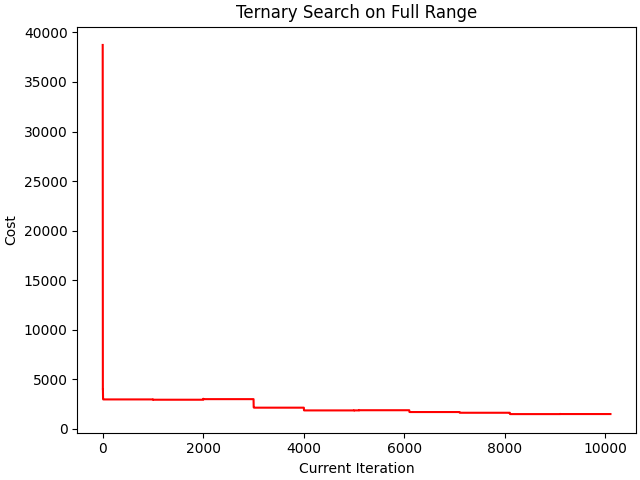

In [93]:
iteration = np.arange(0, costs.shape[0])

# graph the cost after updating the model
fig, cost_graph = plt.subplots(layout='constrained')

cost_graph.set_xlabel("Current Iteration")
cost_graph.set_ylabel("Cost")
cost_graph.set_title("Ternary Search")

cost_graph.plot(iteration, costs, color="r")

In [73]:
print("w:", w.reshape((-1)))
print("b:", b)
print("1st Cost:", costs[0])
print("Nth Cost:", costs[-1])

w: [ 304.1830684141594    16.86747575010057  346.
  345.99999999999943   93.23779171589993  -25.4788009029456
 -345.9999999999992   107.69078507062387  296.3309855967013
  -45.9313080248782 ]
b: 152.13348440463074
1st Cost: 38734.19167923582
Nth Cost: 1736.1518132837707


This is very interesting. Firstly, the cost dropped rapidly when updating the intercept so clearly the intercept is very significant to the cost. Then when updating the weights it didn't drop as much but still reduced a bit. The bigger issue however is how the cost is bigger than the gradient descent version which ranks at 1400 while this is 1700. This is primarily due to the precision issue where two very close inputs lead to the same output. I need to figure out a way to avoid precisions. One post suggests that golden section search could be used for better accuracy instead. 

In [74]:
def golden_section_search(func, l, r, max_iter=1000, epsilon=1e-12):
    it = 0
    newcosts = np.empty(0)

    gr = (math.sqrt(5) + 1) / 2
    while abs(r - l) > epsilon and it <= max_iter:
        left_third = l + (r - l) / gr
        right_third = r - (r - l) / gr

        fl = func(left_third)
        fr = func(right_third)

        if fr < fl:
            r = right_third
            newcosts = np.append(newcosts, fr)
        else:
            l = left_third
            newcosts = np.append(newcosts, fl)
    it += 1

    return newcosts

In [75]:
w, b, costs = perform_search(data, severity, golden_section_search, mse_cost)

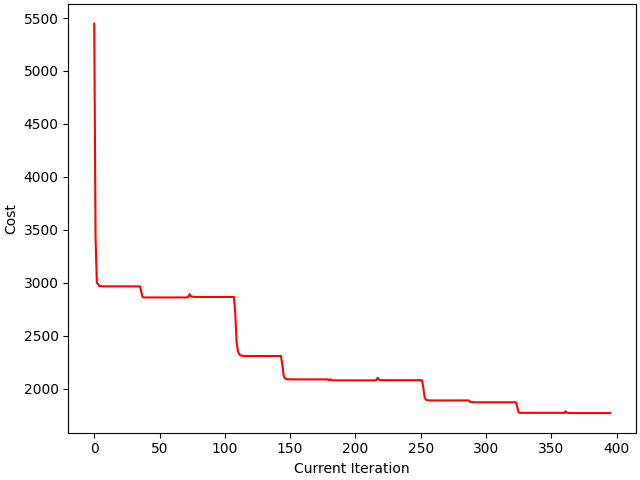

In [76]:
iteration = np.arange(0, costs.shape[0])

# graph the cost after updating the model
fig, cost_graph = plt.subplots(layout='constrained')

cost_graph.set_xlabel("Current Iteration")
cost_graph.set_ylabel("Cost")

cost_graph.plot(iteration, costs, color="r")

In [77]:
print("w:", w.reshape((-1)))
print("b:", b)
print("1st Cost:", costs[0])
print("Nth Cost:", costs[-1])

w: [ 307.4361617194906    81.67952021493473  345.999999999999
  345.999999999999     90.78320752265213  -81.6795202149282
 -345.9999999999925   120.24335849550835  307.43616171944603
  -81.6795202149282 ]
b: 153.18080859709002
1st Cost: 5446.82296644603
Nth Cost: 1768.62539207222


Very similar result with gss as ternary search. So for sure there is a precision issue. I tried feature scaling the output as well to make sure values don't blow up but doesn't seem to help as precision issues will still be a thing no matter the range of values. Let's use mpmath with arbitrary precision and see if we can get better results.

In [78]:
import mpmath
digits = 30 # digits simulates close to float128 data type
mpmath.mp.dps = digits

def mse_cost_precision(w,b,x,y):
    m = x.rows # number of training examples

    prediction = x * w + b
    error = prediction - y
    errorT = error.T
    
    cost = (errorT * error)[0,0] / (2*m)

    return cost

In [79]:
def ternary_search_precision(func, l, r, max_iter=1000):
    it = 0
    newcosts = np.empty(0)

    epsilon = mpmath.mpf(f"1e-{digits}")
    while mpmath.fabs(r - l) > epsilon and it <= max_iter:
        left_third = l + (r - l) / 3
        right_third = r - (r - l) / 3

        fl = func(left_third)
        fr = func(right_third)

        if fl < fr:
            r = right_third
            newcosts = np.append(newcosts, float(fr))
        else:
            l = left_third
            newcosts = np.append(newcosts, float(fl))

        it += 1
    return newcosts

In [80]:
def perform_search_precision(x,y,search_function,cost_function):
    m = x.shape[0] # number of training examples
    n = x.shape[1] # number of features

    out_max = mpmath.mpf(np.max(y))
    out_min = -out_max # ranges for search

    x = mpmath.matrix(x.tolist())
    y = mpmath.matrix(y.tolist())
    w = np.zeros((n,1))
    w = mpmath.matrix(w.tolist()) 
    b = mpmath.mpf(0.0) # convert to mpmath types

    costs = np.empty(0)

    cur_weight_index = 0 # index to choose which weight to update

    def eval_weights_cost(inp):
        w[cur_weight_index,0] = inp
        return cost_function(w, b, x, y)

    def eval_intercept_cost(inp):
        nonlocal b
        b = inp
        return cost_function(w, b, x, y)

    # go through the intercept now
    new_costs = search_function(eval_intercept_cost, out_min, out_max) # perform the search 
    costs = np.append(costs, new_costs) # update costs

    for i in range(n): # go through all weights
        new_costs = search_function(eval_weights_cost, out_min, out_max) # perform the search 

        costs = np.append(costs, new_costs) # update costs
        cur_weight_index += 1 # go to next weight index
    return w, b, costs

In [81]:
w, b, costs = perform_search_precision(data, severity, ternary_search_precision, mse_cost_precision)

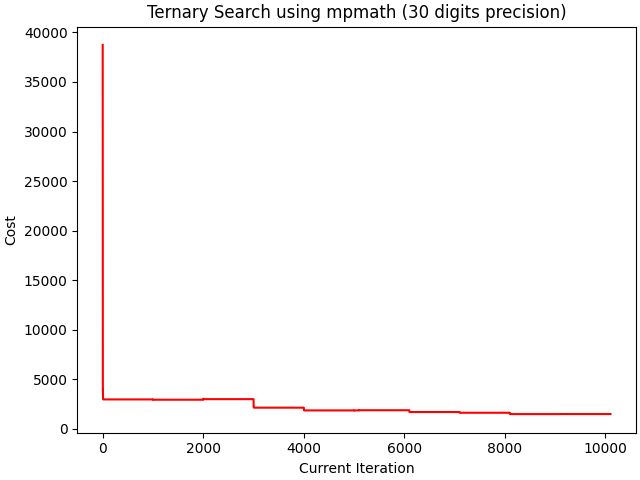

In [94]:
iteration = np.arange(0, costs.shape[0])

# graph the cost after updating the model
fig, cost_graph = plt.subplots(layout='constrained')

cost_graph.set_xlabel("Current Iteration")
cost_graph.set_ylabel("Cost")
cost_graph.set_title("Ternary Search using mpmath (30 digits precision)")

cost_graph.plot(iteration, costs, color="r")

In [83]:
print("w:", w)
print("b:", b)
print("1st Cost:", costs[0])
print("Nth Cost:", costs[-1])

w: [ 304.183074528306275488101367149]
[ 16.8674702693272930830092846006]
[                           346.0]
[                           346.0]
[ 93.2377815731563948981726444133]
[-25.4788110199370846915370359793]
[-345.999999999999999999999999999]
[ 107.690795871669278394637819115]
[ 296.330979315445484311324997915]
[-45.9312923298114445535992573655]
b: 152.133484162895954783447667947
1st Cost: 38734.191679235795
Nth Cost: 1736.1518094495307


Wow, this absolutely sucks. Even with 30 digits of precision, ternary search isn't able to find the minimum. The costs get super small to where even 30 digits of precision aren't actually enough. Though you can observe that cost has lowered only a bit from before when only using 15 digits of precision. Let's try to set an optimal range of weights from the weights we got from gradient descent and see if ternary search performs better.

In [84]:
def mse_cost(w,b,x,y):
    m = x.shape[0] # number of training examples
    
    prediction = np.matmul(x, w) + b
    error = prediction - y
    error = error.reshape((-1)) # make it m (1d array) from mx1
    
    return np.dot(error, error) / (2*m)

In [89]:
def perform_search_fake_weights(x,y,search_function,cost_function):
    m = x.shape[0] # number of training examples
    n = x.shape[1] # number of features

    w = np.zeros((n,1))
    b = 0.0 # initialize model parameters

    weight_ranges = np.array([  -2.46599763, -225.01427119, 515.18188625,  315.32548313,  -54.0633404, -117.13314535, -208.24751658,  122.23408093,  438.87518952, 97.14937745])
    # predefined weights from gradient descent

    delta_ranges = 50
    weight_ranges_min = weight_ranges - delta_ranges
    weight_ranges_max = weight_ranges + delta_ranges 
    # ranges for the weights

    costs = np.empty(0)

    cur_weight_index = 0 # index to choose which weight to update

    out_max = np.max(y)
    out_min = -out_max # ranges for the intercept

    def eval_weights_cost(inp):
        w[cur_weight_index][0] = inp
        return cost_function(w, b, x, y)

    def eval_intercept_cost(inp):
        nonlocal b
        b = inp
        return cost_function(w, b, x, y)

    # go through the intercept now
    new_costs = search_function(eval_intercept_cost, out_min, out_max) # perform the search 
    costs = np.append(costs, new_costs) # update costs

    for i in range(n): # go through all weights
        new_costs = search_function(eval_weights_cost, weight_ranges_min[i], weight_ranges_max[i]) # perform the search 

        costs = np.append(costs, new_costs) # update costs
        cur_weight_index += 1 # go to next weight index
    return w, b, costs

In [90]:
w, b, costs = perform_search_fake_weights(data, severity, ternary_search, mse_cost)

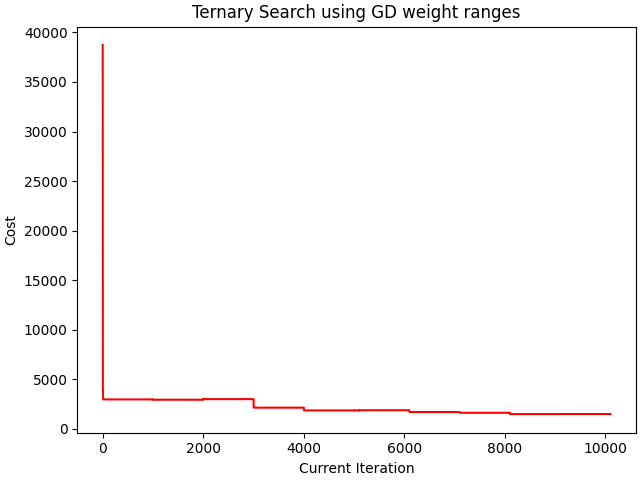

In [95]:
iteration = np.arange(0, costs.shape[0])

# graph the cost after updating the model
fig, cost_graph = plt.subplots(layout='constrained')

cost_graph.set_xlabel("Current Iteration")
cost_graph.set_ylabel("Cost")
cost_graph.set_title("Ternary Search using GD weight ranges")

cost_graph.plot(iteration, costs, color="r")

In [92]:
print("w:", w.reshape(-1))
print("b:", b)
print("1st Cost:", costs[0])
print("Nth Cost:", costs[-1])

w: [  47.53400237        -175.01427119         565.18188625
  365.32548313          -4.063340400000002  -67.13314535
 -258.2475165799992    172.23408092999952   388.8751895200062
   47.14937745000252 ]
b: 152.13348440463074
1st Cost: 38734.19167923582
Nth Cost: 1489.1313358001073


Interesting cost. If we use the weights we got from gradient descent but still make the range big so ternary search has to figure out the actual weights, then the search performs a lot better than with a bigger range. This clearly shows the precision issue problem we have with computers. When doing function evaluations, we must make sure that we don't run out of precision. Even with 30 digits of precision which is equivalent to float128, we still couldn't get anywhere near the gradient descent weights. In math, functions are meant to be performed with unlimited precision so it works out properly and ternary search in theory is better than gradient descent for unimodal functions. But practically, we see that precision is much more important than we think. This also shows us another insight in that gradient descent is very numerically stable. This is more crucial than we expect and another reason why gradient descent is used over ternary search.

There are certain requirements to use ternary search from online research. We need a cost function that is strongly convex unlike the MSE. Strongly convex means that the curvature of the function is steep compared to shallow. Shallow curves make precision much more important and hence ternary search fails to converge. So in practice, we can try ternary search if we recognize or modify the cost function to be strongly convex.